## Code Explanation

### 1. Log-Relative Prices (`lr_*`)

To capture the relative change in prices between time periods, we calculate the log-relative returns for the stock's open, high, low, and close prices. The log-relative price is defined as:

$$
lr\_price = \log\left(\frac{\text{price}}{\text{previous\_close}}\right)
$$

where `price` refers to open, high, low, or close prices, and `previous_close` is the close price of the previous time period.

### 2. Target Variable Creation (`lr_close_t+1`)

The target variable for prediction is the log-relative close price for the next time period, `lr_close_t+1`. This is achieved by shifting the `lr_close` column by one period:

$$
lr\_close\_t+1 = lr\_close.shift(-1)
$$

### 3. Z-Score Normalization for Volume (`z_score_volume`)

To normalize the trading volume and reduce the impact of varying scales, we use Z-score normalization. The Z-score for volume is computed as:

$$
z\_score\_volume = \frac{\text{volume} - \text{rolling\_mean}}{\text{rolling\_std}}
$$

where `rolling_mean` and `rolling_std` are the rolling mean and standard deviation of the volume over a specified window.

### 4. Data Splitting (`train_test_split`)

We split the dataset into training and testing sets to evaluate the model's performance. The splitting is done using the `train_test_split` function, where the test size is set to 20% of the data:

$$
X_{train}, X_{test}, y_{train}, y_{test} = \text{train\_test\_split}(X, y, \text{test\_size}=0.2)
$$

### 5. Random Forest Model Training and Evaluation (`RandomForestRegressor`)

The Random Forest model is trained using the specified hyperparameters, and the model's performance is evaluated on both the training and testing datasets. The metrics calculated include:

- **Root Mean Squared Error (RMSE):**

$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

- **Mean Absolute Error (MAE):**

$$
MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

- **R-squared (R²):**

$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

where \(y_i\) is the actual value, \(\hat{y}_i\) is the predicted value, and \(\bar{y}\) is the mean of the actual values.

### 6. Trend Accuracy

Trend accuracy measures how often the model correctly predicts the direction of price movement. It is defined as the proportion of times the predicted trend matches the actual trend:

$$
\text{Trend Accuracy} = \frac{\text{Number of Correct Trends}}{\text{Total Number of Predictions}}
$$

The trend is determined by the sign of the difference between consecutive points, calculated as:

$$
\text{Trend} = \text{sign}(y_{t+1} - y_t)
$$

### 7. Visualization

The results of the Random Forest Regressor are visualized using various plots:

- **Scatter Plots:** Display the actual vs. predicted values for both training and testing datasets.
- **Residuals Plots:** Show the residuals (errors) between the actual and predicted values.
- **Feature Importance:** Visualizes the importance of each feature in the model.
- **Time Series Plots:** Show the actual vs. predicted values over time for both training and testing datasets.

These visualizations help in understanding the model's performance and identifying any potential areas for improvement.


Training Data - RMSE: 0.0007468922146511446, MAE: 0.00018671731466685218, R²: 0.6521166486270729
Testing Data - RMSE: 0.0009418875996759627, MAE: 0.0004395554210108304, R²: -0.12908980199454723
Trend Accuracy on Testing Data: 52.89%
                 Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  \
0  Tuned Random Forest    0.000747   0.000942   0.000187   0.00044  0.652117   

   Test R²  Trend Accuracy  
0 -0.12909       52.888477  


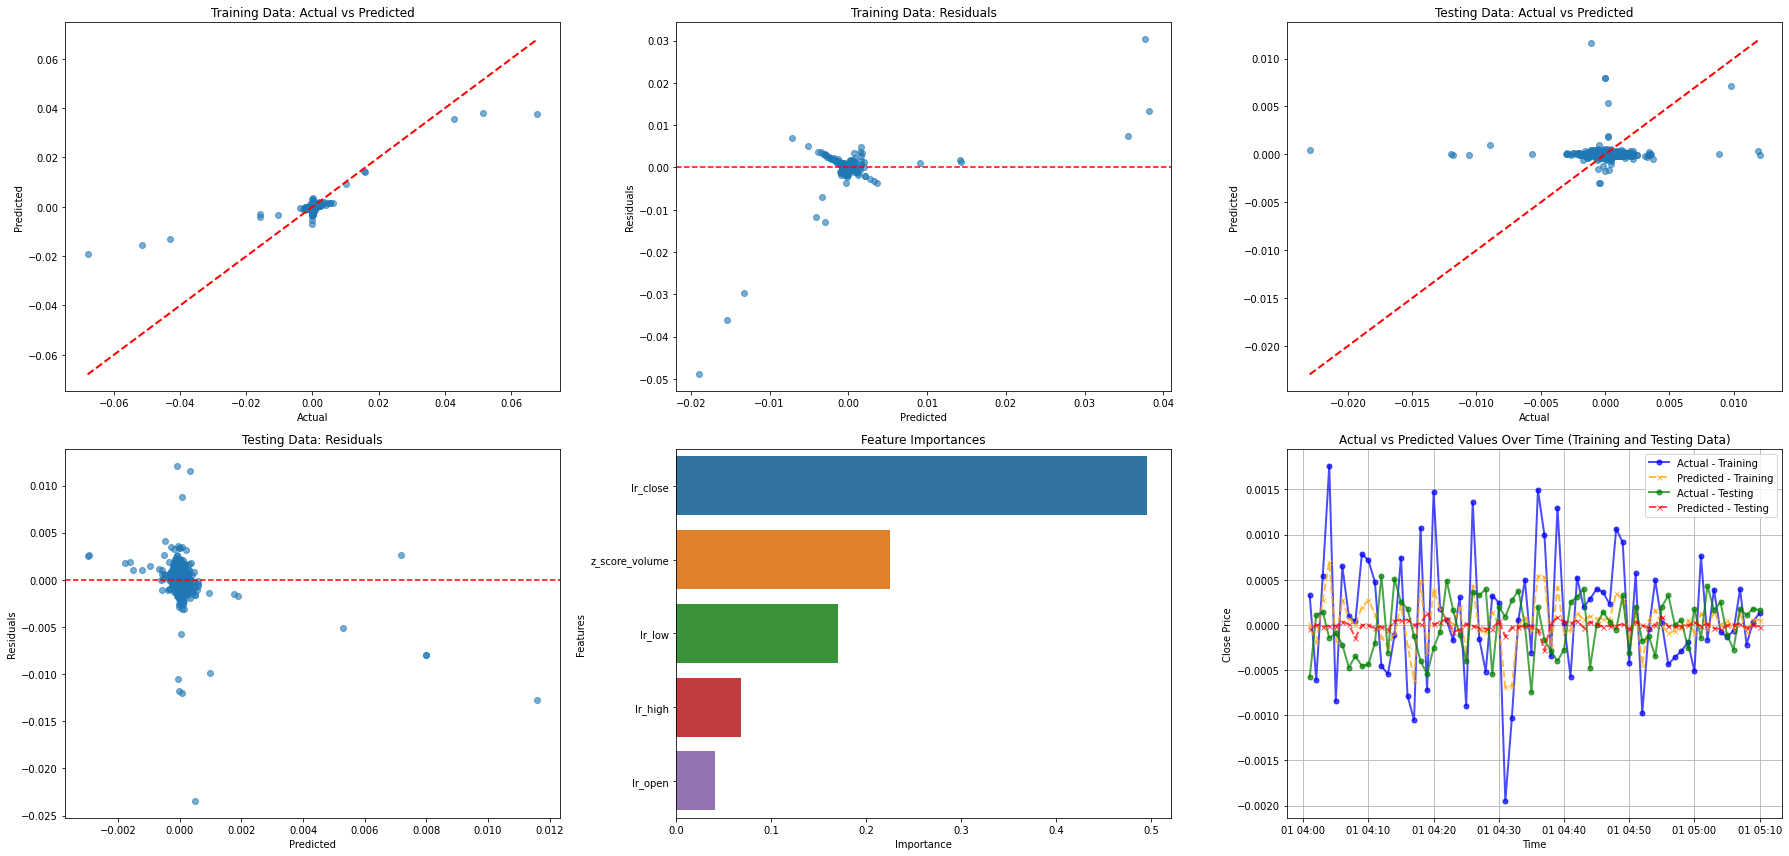

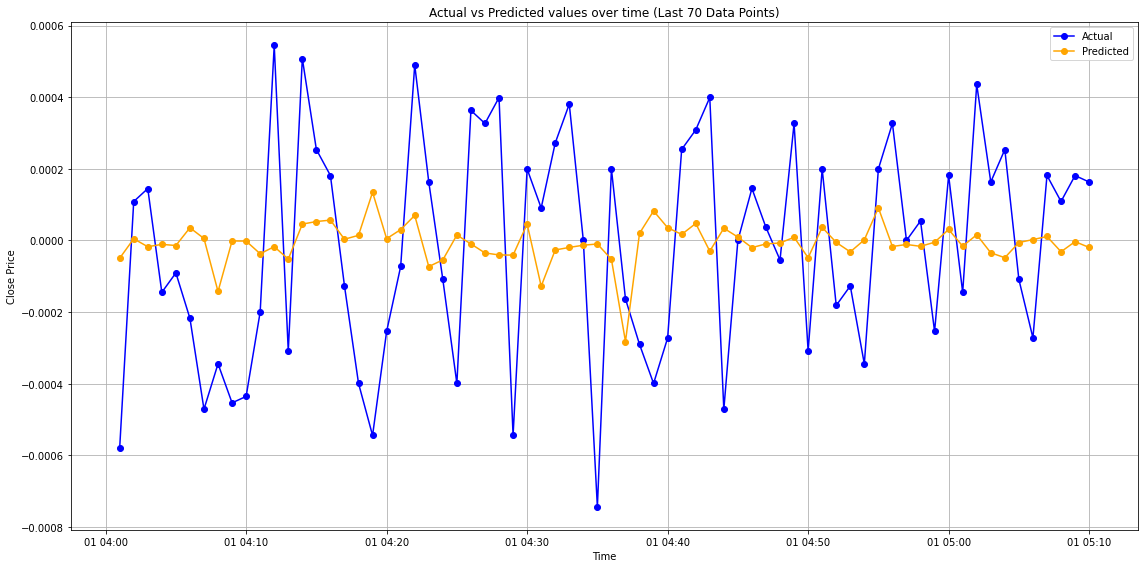

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load and prepare data
def load_and_prepare_data(filepath, sort_by='timestamp', ascending=False):
    data = pd.read_csv(filepath, parse_dates=['timestamp'], index_col='timestamp')
    data.sort_values(by=sort_by, ascending=ascending, inplace=True)
    for col in ['open', 'high', 'low', 'close']:
        data[f'lr_{col}'] = np.log(data[col] / data['close'].shift(-1))
    data.dropna(inplace=True)
    return data

# Function to create the target variable
def create_target_variable(data, shift_by=1):
    data['lr_close_t+1'] = data['lr_close'].shift(shift_by)
    data.dropna(inplace=True)
    return data

# Function to apply Z-score normalization to the volume
def z_score_volume(data, window=60):
    rolling_mean = data['volume'].rolling(window).mean()
    rolling_std = data['volume'].rolling(window).std()
    data['z_score_volume'] = (data['volume'] - rolling_mean) / rolling_std
    data.dropna(inplace=True)
    return data

# Function to split data into training and testing sets
def split_data(data, features, target, test_size=0.2, shuffle=False):
    X = data[features]
    y = data[target]
    return train_test_split(X, y, test_size=test_size, shuffle=shuffle)

# Function to train and evaluate a RandomForestRegressor model
def train_and_evaluate_model(X_train, y_train, X_test, y_test, best_params):
    model = RandomForestRegressor(**best_params, random_state=42)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    metrics = {
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'feature_importances': model.feature_importances_
    }
    
    return model, y_train_pred, y_test_pred, metrics

# Function to calculate trend accuracy
def calculate_trend_accuracy(y_true, y_pred):
    actual_trend = np.sign(np.diff(y_true))
    predicted_trend = np.sign(np.diff(y_pred))
    trend_accuracy = np.mean(actual_trend == predicted_trend)
    return trend_accuracy * 100

# Function to plot RandomForestRegressor results
def plot_rfr_results(y_train, y_train_pred, y_test, y_test_pred, feature_importances, feature_names, data, last_n=70):
    feature_importances_df = pd.DataFrame(feature_importances, index=feature_names, columns=['Importance']).sort_values('Importance', ascending=False)

    plt.figure(figsize=(25, 12))
    plot_scatter(y_train, y_train_pred, 'Training Data: Actual vs Predicted', 1)
    plot_residuals(y_train_pred, y_train, 'Training Data: Residuals', 2)
    plot_scatter(y_test, y_test_pred, 'Testing Data: Actual vs Predicted', 3)
    plot_residuals(y_test_pred, y_test, 'Testing Data: Residuals', 4)
    plot_feature_importance(feature_importances_df, 5)
    plot_time_series(data, y_train, y_train_pred, y_test, y_test_pred, last_n, 6)
    plt.tight_layout()
    plt.show()

    plot_last_n_time_series(data, y_test, y_test_pred, last_n)

def plot_scatter(y_true, y_pred, title, position):
    plt.subplot(2, 3, position)
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)

def plot_residuals(y_pred, y_true, title, position):
    plt.subplot(2, 3, position)
    plt.scatter(y_pred, y_true - y_pred, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title(title)

def plot_feature_importance(feature_importances_df, position):
    plt.subplot(2, 3, position)
    sns.barplot(x=feature_importances_df['Importance'], y=feature_importances_df.index)
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Features')

def plot_time_series(data, y_train, y_train_pred, y_test, y_test_pred, last_n, position):
    plt.subplot(2, 3, position)
    plt.plot(data.index[-last_n:], y_train[-last_n:], label='Actual - Training', color='blue', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
    plt.plot(data.index[-last_n:], y_train_pred[-last_n:], label='Predicted - Training', color='orange', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)
    plt.plot(data.index[-last_n:], y_test[-last_n:], label='Actual - Testing', color='green', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
    plt.plot(data.index[-last_n:], y_test_pred[-last_n:], label='Predicted - Testing', color='red', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)
    plt.title('Actual vs Predicted Values Over Time (Training and Testing Data)')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)

def plot_last_n_time_series(data, y_test, y_test_pred, last_n):
    plt.figure(figsize=(16, 8))
    time_series = data.index[-last_n:]
    y_test_actual_last_n = y_test[-last_n:]
    y_test_pred_last_n = y_test_pred[-last_n:]

    plt.plot(time_series, y_test_actual_last_n, label='Actual', color='blue', marker='o')
    plt.plot(time_series, y_test_pred_last_n, label='Predicted', color='orange', marker='o')

    plt.title(f'Actual vs Predicted values over time (Last {last_n} Data Points)')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    filepath = 'SPY_2024-08.csv'
    data = load_and_prepare_data(filepath)
    data = create_target_variable(data)
    data = z_score_volume(data)

    features = ['lr_open', 'lr_high', 'lr_low', 'lr_close', 'z_score_volume']
    target = 'lr_close_t+1'

    X_train, X_test, y_train, y_test = split_data(data, features, target)

    best_params = {
        'max_depth': 20, 
        'max_features': 'sqrt', 
        'min_samples_leaf': 2, 
        'min_samples_split': 2, 
        'n_estimators': 300
    }

    model, y_train_pred, y_test_pred, metrics = train_and_evaluate_model(X_train, y_train, X_test, y_test, best_params)

    print(f"Training Data - RMSE: {metrics['train_rmse']}, MAE: {metrics['train_mae']}, R²: {metrics['train_r2']}")
    print(f"Testing Data - RMSE: {metrics['test_rmse']}, MAE: {metrics['test_mae']}, R²: {metrics['test_r2']}")

    trend_accuracy = calculate_trend_accuracy(y_test, y_test_pred)
    print(f"Trend Accuracy on Testing Data: {trend_accuracy:.2f}%")

    results = {
        'Model': ['Tuned Random Forest'],
        'Train RMSE': [metrics['train_rmse']],
        'Test RMSE': [metrics['test_rmse']],
        'Train MAE': [metrics['train_mae']],
        'Test MAE': [metrics['test_mae']],
        'Train R²': [metrics['train_r2']],
        'Test R²': [metrics['test_r2']],
        'Trend Accuracy': [trend_accuracy]
    }

    results_df = pd.DataFrame(results)
    print(results_df)
    results_df.to_csv('tuned_model_performance_metrics_with_trend_accuracy.csv', index=False)

    plot_rfr_results(
        y_train=y_train,
        y_train_pred=y_train_pred,
        y_test=y_test,
        y_test_pred=y_test_pred,
        feature_importances=metrics['feature_importances'],
        feature_names=features,
        data=data,
        last_n=70
    )
